In [1]:
import random
from collections import deque
import numpy as np
import gym
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Memory:
    def __init__(self):
        self.buffer = deque(maxlen=20000)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def get(self):
        states, actions, rewards, next_states, dones = map(np.asarray, zip(*self.buffer))
        states = tf.constant(states, dtype=tf.float32)
        if len(actions.shape) == 1:
            actions = actions.reshape((-1, 1))
        actions = tf.constant(actions, dtype=tf.float32)
        rewards = tf.expand_dims(tf.constant(rewards, dtype=tf.float32), axis=1)
        next_states = tf.constant(next_states, dtype=tf.float32)
        dones = tf.expand_dims(tf.constant(dones, dtype=tf.float32), axis=1)

        return tf.data.Dataset.from_tensor_slices((states, actions, rewards, next_states, dones))

    def forget(self):
        self.buffer.clear()

    def __len__(self):
        return len(self.buffer)

In [3]:
class Actor(tf.keras.Model):
    def __init__(self, output_dim=1, hidden=32, activation="elu", name="actor", **kwargs):
        super().__init__(self, name=name, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.dense1 = tf.keras.layers.Dense(hidden, 
                                            activation=activation,
                                            use_bias=True,
                                            kernel_initializer="lecun_normal",
                                            bias_initializer="lecun_uniform"
                                            )
        self.dense2 = tf.keras.layers.Dense(hidden, 
                                            activation=activation,
                                            use_bias=True,
                                            kernel_initializer="lecun_normal",
                                            bias_initializer="lecun_uniform"
                                            )
        self.out = tf.keras.layers.Dense(output_dim, activation=activation, use_bias=True)
    
    def call(self, inputs):
        x = self.bn(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

class Critic(tf.keras.Model):
    def __init__(self, output_dim=1, hidden=32, activation="selu", name="critic", **kwargs):
        super().__init__(self, name=name, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.dense1 = tf.keras.layers.Dense(hidden, 
                                            activation=activation,
                                            use_bias=True,
                                            kernel_initializer="lecun_normal",
                                            bias_initializer="lecun_uniform"
                                            )
        self.dense2 = tf.keras.layers.Dense(hidden, 
                                            activation=activation,
                                            use_bias=True,
                                            kernel_initializer="lecun_normal",
                                            bias_initializer="lecun_uniform"
                                            )
        self.out = tf.keras.layers.Dense(output_dim, activation=activation, use_bias=True)
    
    def call(self, inputs):
        x = self.bn(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x) 

In [4]:
class PPO:
    def __init__(self, 
                 env=None, 
                 hidden=32,
                 policy_clip=0.2,
                 entropy_coef=0.1,
                 value_coef=0.5,
                 std_init=0.2,
                 gamma=0.99,
                 lambda_=0.95,
                 episodes=1000,
                 batch_size=32, 
                 actor_lr=1e-4,
                 critic_lr=2e-4,
                 seed=None
                 ):
        self.env = env

        self.actor = Actor(hidden=hidden, name="actor")
        self.critic = Critic(hidden=hidden, name="critic")
        self.actor_old = Actor(hidden=hidden, name="actor_old")
        self.critic_old = Critic(hidden=hidden, name="critic_old")
        self.critic_old.build(input_shape=(batch_size, 2))

        self.policy_clip = policy_clip
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.scale_diag = tf.fill(1, std_init)
        self.gamma = gamma
        self.lambda_ = lambda_

        self.episodes = episodes
        self.batch_size = batch_size
        self.actor_opt = tf.keras.optimizers.Adam(learning_rate=actor_lr)
        self.critic_opt = tf.keras.optimizers.Adam(learning_rate=critic_lr)

        self.memo = Memory()
        self.istraining = True
        if seed:
            tf.keras.backend.clear_session()
            self.env.seed(seed)
            random.seed(seed)
            np.random.seed(seed)
            tf.random.set_seed(seed)
        self.writer = tf.summary.create_file_writer("./recording/ppo/")
        self.history = {}

    def calc_advantages(self, values, rewards, next_states, dones):
        gae = 0
        advs = []
        for step in reversed(range(len(dones))):
            delta = (rewards[step]
                     + self.gamma * next_states[step] * (1 - dones[step]) 
                     - values[step])
            gae = delta + self.gamma * self.lambda_ * gae
            advs.insert(0, gae)
        return tf.stack(advs)

    def get_distri(self, mu, scale_diag, name='MultivariateNormalDiag'):
        distri = tfp.distributions.MultivariateNormalDiag(loc=mu, 
                                                          scale_diag=scale_diag,
                                                          name=name)
        return distri

    def calc_loss(self, states, actions, rewards, next_states, dones):
        action_mu, values = self.actor(states), self.critic(states)
        action_mu_old = self.actor_old(states)
        next_values = self.critic(next_states)

        target_values = rewards + self.gamma * next_values * (1 - dones)
        value_loss = tf.reduce_mean(tf.sqrt(tf.square(target_values - values)))

        distri = self.get_distri(action_mu, self.scale_diag, name="cur_distribution")
        distri_old = self.get_distri(action_mu_old, self.scale_diag, name="old_distribution")
        
        entropy_loss = tf.reduce_mean(distri.entropy())

        advantages = self.calc_advantages(values, rewards, next_states, dones)
        logprob = tf.expand_dims(distri.log_prob(actions), axis=1)
        logprob_old = tf.stop_gradient(tf.expand_dims(tf.math.log(distri_old.prob(actions) 
                                       + 1e-6), axis=1))
        ratios = tf.math.exp(logprob - logprob_old)

        surrogate = tf.clip_by_value(ratios, 
                                     clip_value_min=1. - self.policy_clip, 
                                     clip_value_max=1. + self.policy_clip) * advantages
        surrogate_loss = tf.reduce_mean(surrogate)

        loss = value_loss * self.value_coef - entropy_loss * self.entropy_coef - surrogate_loss
        self.history["policy_loss"] = surrogate_loss
        self.history["value_loss"] = value_loss
        self.history["entropy_loss"] = entropy_loss
        return loss

    # @tf.function
    def training(self, states, actions, rewards, next_states, dones):
        with tf.GradientTape(persistent=True) as tape:
            loss = self.calc_loss(states, actions, rewards, next_states, dones)
        grad_actor = tape.gradient(loss, self.actor.trainable_variables)
        grad_critic = tape.gradient(loss, self.critic.trainable_variables)
        self.actor_opt.apply_gradients(zip(grad_actor, self.actor.trainable_variables))
        self.critic_opt.apply_gradients(zip(grad_critic, self.critic.trainable_variables))
    
    def updates_old(self):
        self.actor_old.set_weights(self.actor.get_weights())
        self.critic_old.set_weights(self.critic.get_weights())

    def act(self, state):
        state = tf.expand_dims(tf.cast(state, dtype=tf.float32), axis=0)
        action_mu = self.actor(state)
        if self.istraining:
            action_mu = self.get_distri(action_mu, self.scale_diag).sample()
        return np.squeeze(action_mu)

    def play_one_episode(self, env):
        state, done = env.reset(), False
        step_count, reward_sum = 0, 0
        while not done:
            action = self.act(state)
            next_state, reward, done, _ = env.step([action])
            if self.istraining:
                self.memo.push(state, action, reward, next_state, done)
            state = next_state
            step_count += 1
            reward_sum += reward
        return step_count, reward_sum

    def play(self, train_num=5):
        self.steps_record = deque(maxlen=self.episodes)
        self.rewards_record = deque(maxlen=self.episodes)
        train_count = 0
        for epi in range(1, self.episodes + 1):
            step_count, reward_sum = self.play_one_episode(self.env)
            self.steps_record.append(step_count)
            self.rewards_record.append(reward_sum)
            if self.istraining:
                ds = self.memo.get().batch(self.batch_size).prefetch(self.batch_size)
                for i in range(train_num):
                    for states, actions, rewards, next_states, dones in ds:
                        self.training(states, actions, rewards, next_states, dones)
                self.memo.forget()
                self.updates_old()
                train_count += 1
                with self.writer.as_default():
                    tf.summary.scalar("policy_loss", self.history["policy_loss"], step=train_count)
                    tf.summary.scalar("value_loss", self.history["value_loss"], step=train_count)
                    tf.summary.scalar("entropy_loss", self.history["entropy_loss"], step=train_count)
                self.writer.flush()

            print(f"\rEpisode: {epi}, Total steps: {step_count}, Total reward: {reward_sum :.3f}", end="")
            if epi > 0 and epi % 50 == 0:
                plt.plot(self.steps_record)
                plt.show()
                plt.plot(self.rewards_record)
                plt.show()

In [5]:
env = gym.make("MountainCarContinuous-v0")
# min_action = -1.0
# max_action = 1.0
# min_position = -1.2
# max_position = 0.6
# max_speed = 0.07

Episode: 50, Total steps: 999, Total reward: -82.426

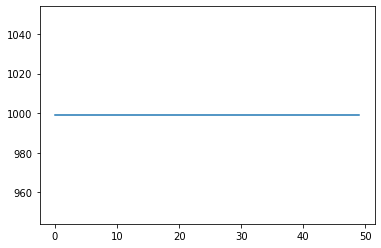

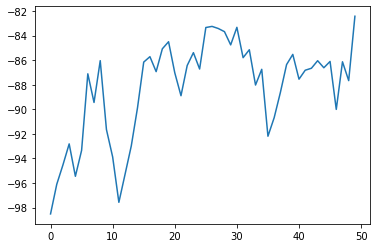

Episode: 100, Total steps: 999, Total reward: -73.235

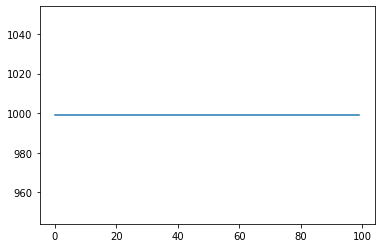

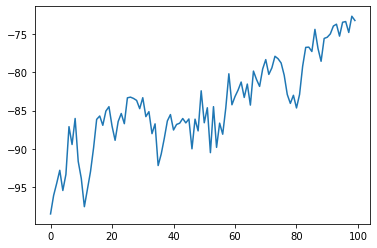

Episode: 150, Total steps: 999, Total reward: -75.756

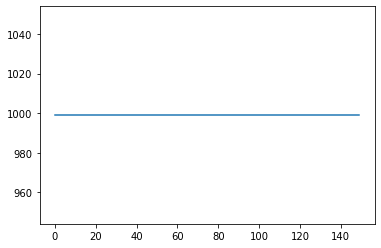

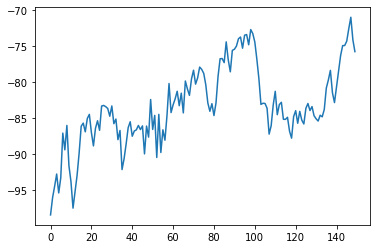

Episode: 200, Total steps: 999, Total reward: -84.667

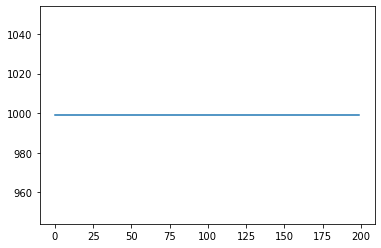

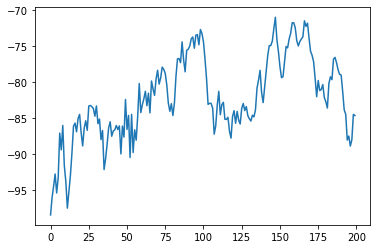

Episode: 250, Total steps: 999, Total reward: -82.753

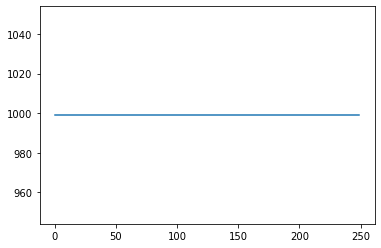

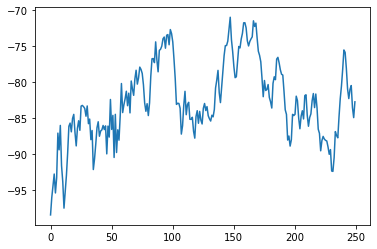

Episode: 300, Total steps: 999, Total reward: -77.595

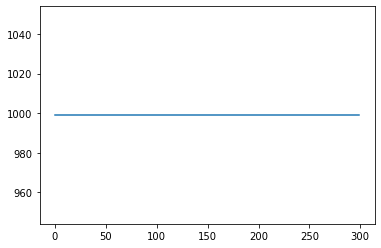

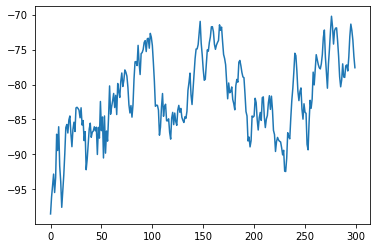

Episode: 350, Total steps: 999, Total reward: -75.221

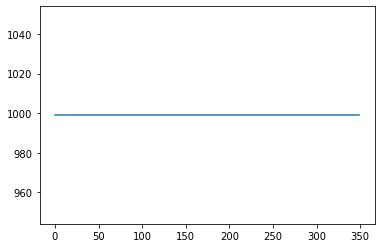

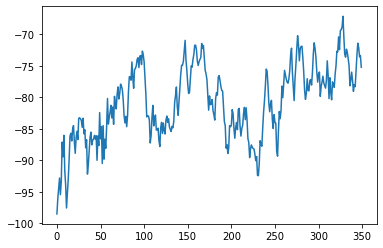

Episode: 400, Total steps: 999, Total reward: -95.458

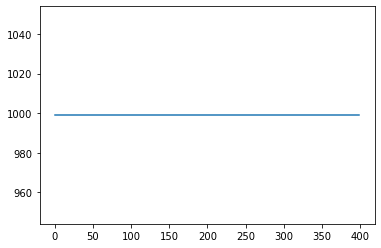

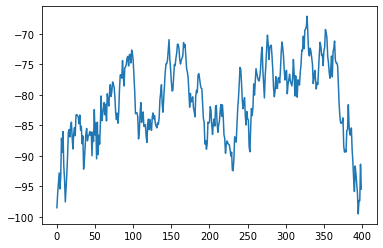

Episode: 450, Total steps: 999, Total reward: -72.669

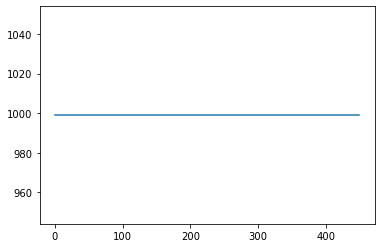

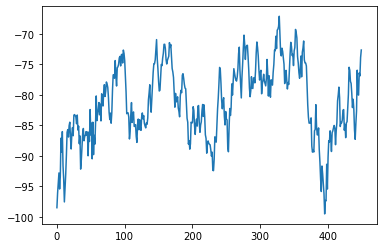

Episode: 500, Total steps: 999, Total reward: -63.116

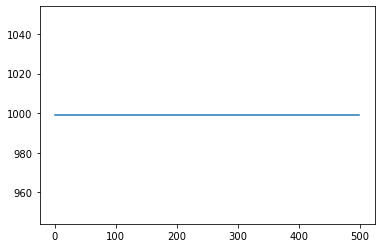

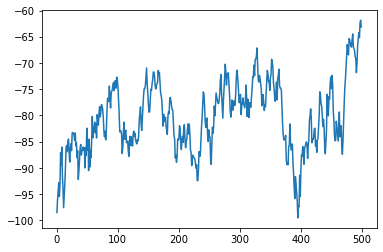

Episode: 550, Total steps: 999, Total reward: -59.747

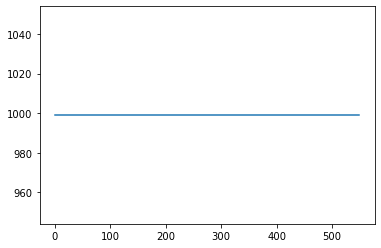

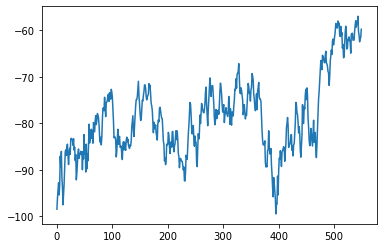

Episode: 600, Total steps: 999, Total reward: -43.419

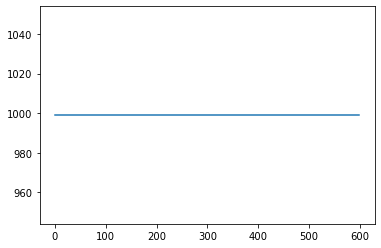

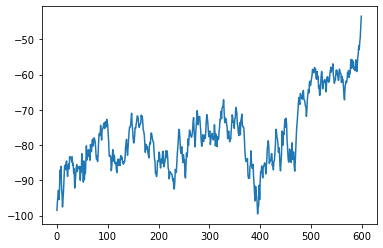

In [6]:
agent = PPO(env=env, 
            hidden=16,
            policy_clip=0.2,
            entropy_coef=0.1,
            value_coef=0.5,
            std_init=0.2,
            gamma=0.99,
            lambda_=0.95,
            episodes=600,
            batch_size=32, 
            actor_lr=1e-4,
            critic_lr=3e-4,
            seed=42
            )
agent.play()